# Wikipedia Articles NLP Project

## Overview

This notebook performs an NLP on random articles collected from [Wikipedia](https://en.wikipedia.org/). It explored different feature extraction and clustering methods.

## Imports

In [ ]:
from gensim import downloader as model_api
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import requests
import scipy.cluster.hierarchy as sch
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import time

## Data Collection

In [2]:
url = 'https://en.wikipedia.org/w/api.php'
csv_path = 'wiki_articles.csv'

In [ ]:
def get_random_titles(n:int) -> list:
    titles = []
    while len(titles) < n:
        try:
            params = {
                'action': 'query',
                'list': 'random',
                'rnnamespace': 0,  # Only articles
                'rnlimit': min(50, n - len(titles)),
                'format': 'json'
            }
            response = requests.get(url, params=params)
            data = response.json()
            batch = [item['title'] for item in data['query']['random']]
            titles.extend(batch)
            time.sleep(0.5)
        except Exception as e:
            print('Error:', e)
            time.sleep(1)
    return titles

In [4]:
def get_article_text(title:str) -> str:
    params = {
        'action': 'query',
        'format': 'json',
        'prop': 'extracts',
        'explaintext': True,
        'titles': title
    }
    try:
        response = requests.get(url, params=params)
        pages = response.json()['query']['pages']
        page = next(iter(pages.values()))
        return page.get('extract', '')
    except Exception as e:
        print(f'Error fetching {title}: {e}')
        return ''

In [5]:
def remove_unwanted_sections(text:str) -> str:
    unwanted_sections = [
        r'==\s*See also\s*==',
        r'==\s*References\s*==',
        r'==\s*Further reading\s*==',
        r'==\s*External links\s*==',
        r'==\s*Notes\s*==',
        r'==\s*Sources\s*==',
        r'==\s*Bibliography\s*==',
        r'==\s*Footnotes\s*=='
    ]

    pattern = re.compile('|'.join(unwanted_sections), re.IGNORECASE)
    match = pattern.search(text)

    if match:
        return text[:match.start()].strip()
    else:
        return text.strip()

In [6]:
def full_clean(text:str) -> str:
    core = remove_unwanted_sections(text)
    core = re.sub(r'\n{2,}', '\n', core)
    return core.strip()

In [7]:
def export_list_to_csv(data:list[dict], csv_path:str) -> None:
	df = pd.DataFrame(data)
	if not os.path.isfile(csv_path):
		df.to_csv(csv_path, index=False)
	else:
		df.to_csv(csv_path, index=False, header=False, mode='a')

In [ ]:
# Get 10000 random articles from Wikipedia
titles = get_random_titles(10000)
chunks = np.array_split(np.array(titles), 100)

In [ ]:
# Export data in chunks
for i, chunk in enumerate(chunks):
	print(f'Chunk {i + 1}/{len(chunks)}')
	wiki_list = []
	for title in chunk:
		text = get_article_text(title)
		if text and len(text) > 300: # Filter out very short pages
			wiki_list.append({
				'title': title,
				'text': full_clean(text)
			})
	 	# Sleep for 500 ms to avoid rate-limiting
		time.sleep(0.5)
	export_list_to_csv(wiki_list, csv_path)
	print(f'Added {len(wiki_list)}/{len(chunk)} articles to CSV file.')

## EDA

In [8]:
# Load data
df = pd.read_csv(csv_path)
df.head()

,title,text
0,Biff Schlitzer,"Victor Joseph ""Biff"" Schlitzer (December 4, 18..."
1,Prabhash Kumar,"Prabhash Kumar is an Indian politician, farmer..."
2,San Carlos Formation,The San Carlos Formation is a geological forma...
3,2023 in Ohio,The following is a list of events of the year ...
4,2009 Iowa special elections,The 2009 Iowa state special elections were hel...


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8595 entries, 0 to 8594
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   8595 non-null   object
 1   text    8595 non-null   object
dtypes: object(2)
memory usage: 134.4+ KB


In [10]:
# Get smallest text
index = df['text'].str.len().idxmin()
df.iloc[index]

,5992
title,List of volcanoes in El Salvador
text,This is a list of active and extinct volcanoes...


In [11]:
# Get biggest text
index = df['text'].str.len().idxmax()
df.iloc[index]

,5321
title,Divided differences
text,"In mathematics, divided differences is an algo..."


## Data Preprocessing

### GloVe

In [12]:
# Tokenize texts by removing punctuation and special characters
# and lowercasing everything
replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
})

rep = dict((re.escape(k),v) for k, v in replaceDict.items())
pattern = re.compile('|'.join(rep.keys()))

def replacer(text):
    return rep[re.escape(text.group(0))]

words = df['text'].str.replace(pattern, replacer, regex=True).str.lower().str.split()
words = pd.DataFrame(words.tolist())

In [13]:
word_vectors = model_api.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


In [14]:
# Function to retrieve the word vector or return a zero vector if the word is not found
def get_word_vector(word):
    if word in word_vectors:
        return word_vectors[word]
    else:
        return np.zeros(word_vectors.vector_size)

# Function to map a text to its vector representation by summing the word vectors
def map_text_to_vector(page):
    return np.sum([get_word_vector(word) for word in page if pd.notna(word)], axis=0)

# Apply the mapping function to each text and create a DataFrame of the results
glove_emb = pd.DataFrame(words.apply(map_text_to_vector, axis=1).tolist())
glove_emb

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-25.553197,61.277992,-6.441907,-1.327819,33.129767,25.303264,-93.681521,-16.925939,-39.743567,-34.605831,...,-31.948293,-17.013292,7.921901,-10.060203,-43.326178,41.130120,-28.867548,-40.196636,-8.029011,-6.774925
1,1.704619,-1.517041,-13.325157,5.417937,20.572402,23.046139,-10.669863,-4.731333,-16.040038,-24.081318,...,-27.581619,14.695299,-22.071071,-11.928519,-20.945080,10.538783,-21.423375,-22.582989,19.028705,-20.659330
2,17.696770,2.319915,-2.985669,5.802332,11.713197,3.547520,-16.159113,-15.404687,-11.138138,-3.644905,...,-26.690475,-17.304464,2.805483,2.516293,0.250916,5.042878,6.546632,-9.455825,2.516218,-19.384553
3,57.877136,42.455009,17.792969,-2.447541,9.637690,54.997059,-98.312935,5.448763,0.324308,-72.113289,...,-66.280624,-2.030703,29.818583,-25.870623,-49.491760,43.662933,-53.715706,-36.119362,10.410617,-42.222218
4,4.474286,20.002575,7.467521,10.103029,37.283440,48.269833,-125.686661,-12.588920,-42.947601,-100.732811,...,-80.048775,35.040638,-52.696964,-45.672440,-89.739273,49.484070,-88.131134,-34.871624,8.551754,27.011698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8590,14.352584,122.384755,-170.521032,-47.543207,33.140047,40.247651,-144.909884,17.184558,-138.784235,-16.838819,...,-45.112582,18.165843,-47.235383,-89.321172,-80.017884,43.918467,-65.476791,-84.576976,-123.467156,-24.511413
8591,186.930886,-73.040578,-125.070949,37.098090,223.528212,191.890156,-199.127123,-234.222369,-46.272845,37.687762,...,22.619779,59.103097,-3.399424,27.933238,331.744119,261.918040,-57.953918,-41.787180,-38.495136,-91.641842
8592,15.554881,26.999107,-32.302677,-13.859942,20.643557,-5.603209,-58.670879,-1.185496,-48.660622,-19.573153,...,-22.711718,4.816690,-11.640561,-36.836224,-58.727997,22.536022,-32.802155,-52.557323,16.080572,-19.773840
8593,53.355042,-24.083059,-6.758219,-5.503126,61.069004,32.600834,-51.542694,7.272554,-10.884201,-61.907169,...,-72.853905,36.391407,35.984333,-12.220505,-5.377378,25.349607,-92.599640,-37.820564,24.898485,-86.716850


### Sentence Transformer

In [15]:
# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [16]:
# Calculate embeddings
mini_emb = pd.DataFrame(model.encode(df['text']))
mini_emb

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.023374,0.023269,-0.103945,-0.033877,0.031884,0.100352,-0.051282,0.155663,-0.035584,0.051362,...,-0.053423,-0.014926,-0.045564,-0.063073,0.016583,-0.078675,0.018316,-0.048807,-0.053580,-0.006450
1,0.001867,-0.012857,-0.052250,-0.035741,0.041092,0.021050,0.093268,-0.023004,-0.087791,0.028738,...,-0.052659,0.017524,-0.082142,-0.061607,-0.000720,0.023933,0.108369,0.060540,-0.015630,-0.011093
2,-0.051594,0.027089,-0.045995,0.067701,-0.045514,-0.002171,-0.086146,-0.015811,-0.035470,-0.026100,...,0.005135,0.006779,0.050991,0.040364,-0.004147,0.011562,-0.047039,0.027455,0.086669,-0.001813
3,-0.006973,0.010959,0.037496,0.016119,0.095530,0.044021,-0.007896,0.041771,-0.131271,0.058207,...,0.041905,0.019995,-0.004059,-0.129669,0.002306,-0.022474,-0.031808,0.017117,0.007192,0.009654
4,-0.046682,-0.012143,0.086666,-0.046343,0.007200,0.052154,-0.024122,0.040913,0.006559,0.040980,...,-0.044681,-0.068946,-0.053276,-0.181910,0.004719,0.064600,0.025116,0.041235,0.016052,-0.075555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8590,0.008887,0.017314,-0.041147,-0.014189,-0.073766,0.079026,-0.019779,0.052027,-0.037399,0.011336,...,0.018744,-0.022396,-0.025683,0.030633,0.007230,-0.019306,0.007542,0.079803,-0.048633,-0.000934
8591,-0.013043,-0.084558,-0.066673,0.016100,0.024330,-0.031969,0.008016,-0.021110,0.055534,-0.042198,...,-0.031272,0.039986,0.023300,-0.063697,0.106172,-0.044735,-0.046021,0.077347,0.082478,0.018576
8592,0.056743,-0.016630,-0.045755,0.021144,-0.031342,-0.050017,-0.061236,0.062345,0.089322,-0.009769,...,-0.092888,0.007519,0.099991,0.052765,0.022278,0.003323,-0.021144,-0.013760,-0.052189,-0.044215
8593,0.059751,0.089780,-0.048822,0.020530,0.057927,0.023562,0.012857,0.002716,0.015486,0.049756,...,0.021733,0.056091,0.006063,-0.078170,0.012723,-0.022446,0.086766,-0.044068,0.004002,-0.003946


## Unsupervised Learning

Three different clustering methods will be explored. The best one will be selected for analyzing and visualization.

### K-Means

Two metrics will be used to determine the optimal k: **Sum of Squared Distances (SSD)** and the **Silhouette Score**. The same metrics will be used to determine the best feature extraction technique.

#### Find optimal K

In [17]:
def create_models(data:pd.DataFrame) -> pd.DataFrame:
  models = []
  for k in range(2, 31):
      kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
      kmeans.fit(data)
      labels = kmeans.labels_
      models.append({
          'k': k,
          'ssd': kmeans.inertia_,
          'silhouette': silhouette_score(data, labels, metric='euclidean'),
      })

  models_df = pd.DataFrame(models).set_index('k')
  return models_df

In [18]:
def display_k_plots(data:pd.DataFrame, technique:str) -> None:
  fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,8), sharex=True)

  # Elbow Method
  kneedle = KneeLocator(data.index, data['ssd'], curve='convex', direction='decreasing')
  optimal_k = kneedle.elbow
  optimal_score = data.loc[optimal_k, 'ssd']
  ax1.plot(data['ssd'], marker='s')
  ax1.set_ylabel('SSD')
  ax1.axvline(x=optimal_k, color='black', linestyle='--')
  ax1.annotate(f'elbow at k = {optimal_k}, score = {round(optimal_score, 4)}', xy=(optimal_k, optimal_score))

  # Silhouette Score
  optimal_k = data['silhouette'].idxmax()
  max_score = data['silhouette'].max()
  ax2.plot(data['silhouette'], marker='s')
  ax2.set_xlabel('k')
  ax2.set_ylabel('Silhouette Score')
  ax2.axvline(x=optimal_k, color='black', linestyle='--')
  ax2.annotate(f'max score at k = {optimal_k}, score = {round(max_score, 4)}', xy=(optimal_k, max_score))

  fig.suptitle(f'Different Metrics for Optimal K ({technique})')
  fig.tight_layout()
  plt.show()

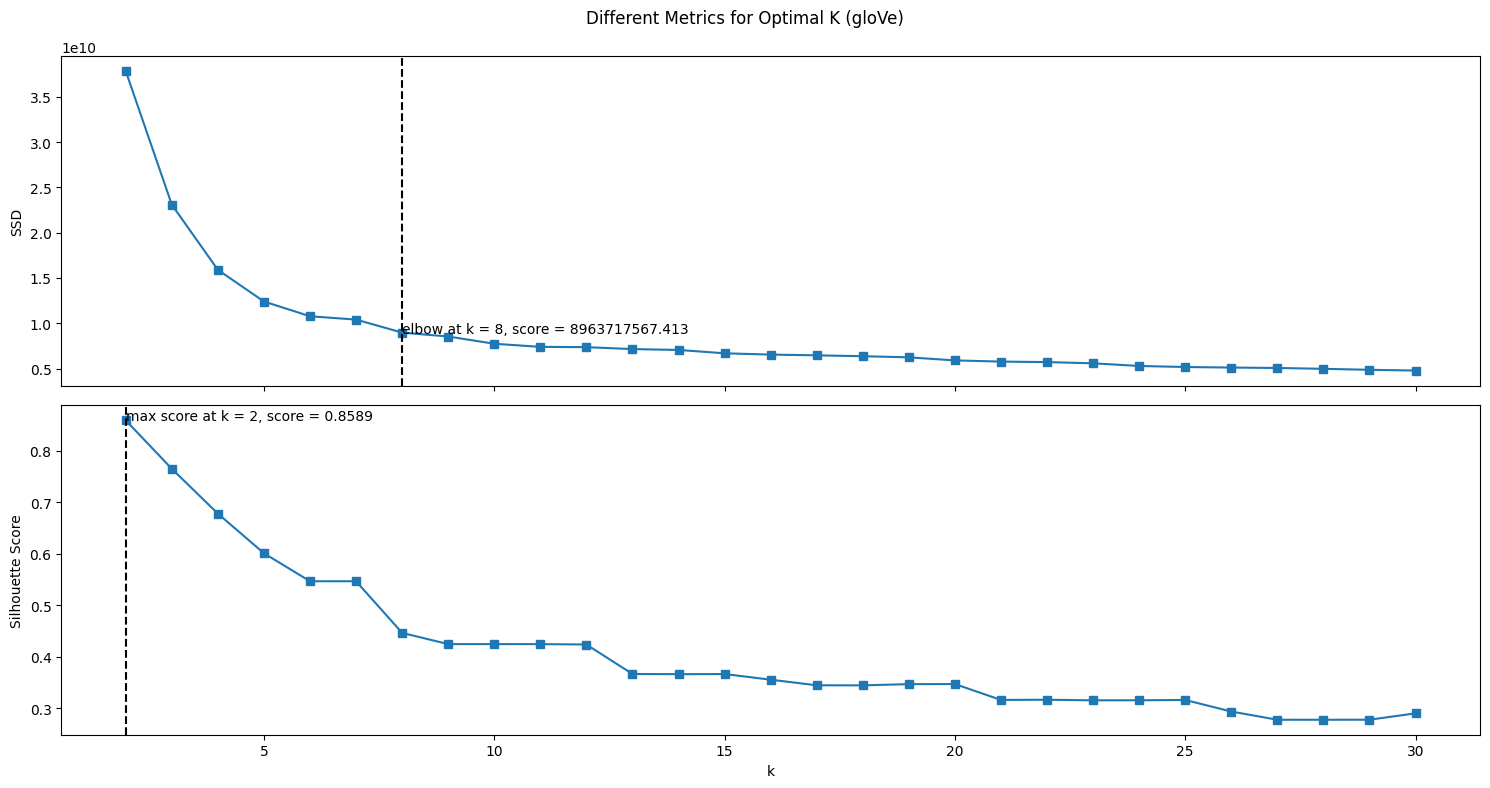

In [19]:
# Display plots for gloVe
metrics_df = create_models(glove_emb)
display_k_plots(metrics_df, 'gloVe')

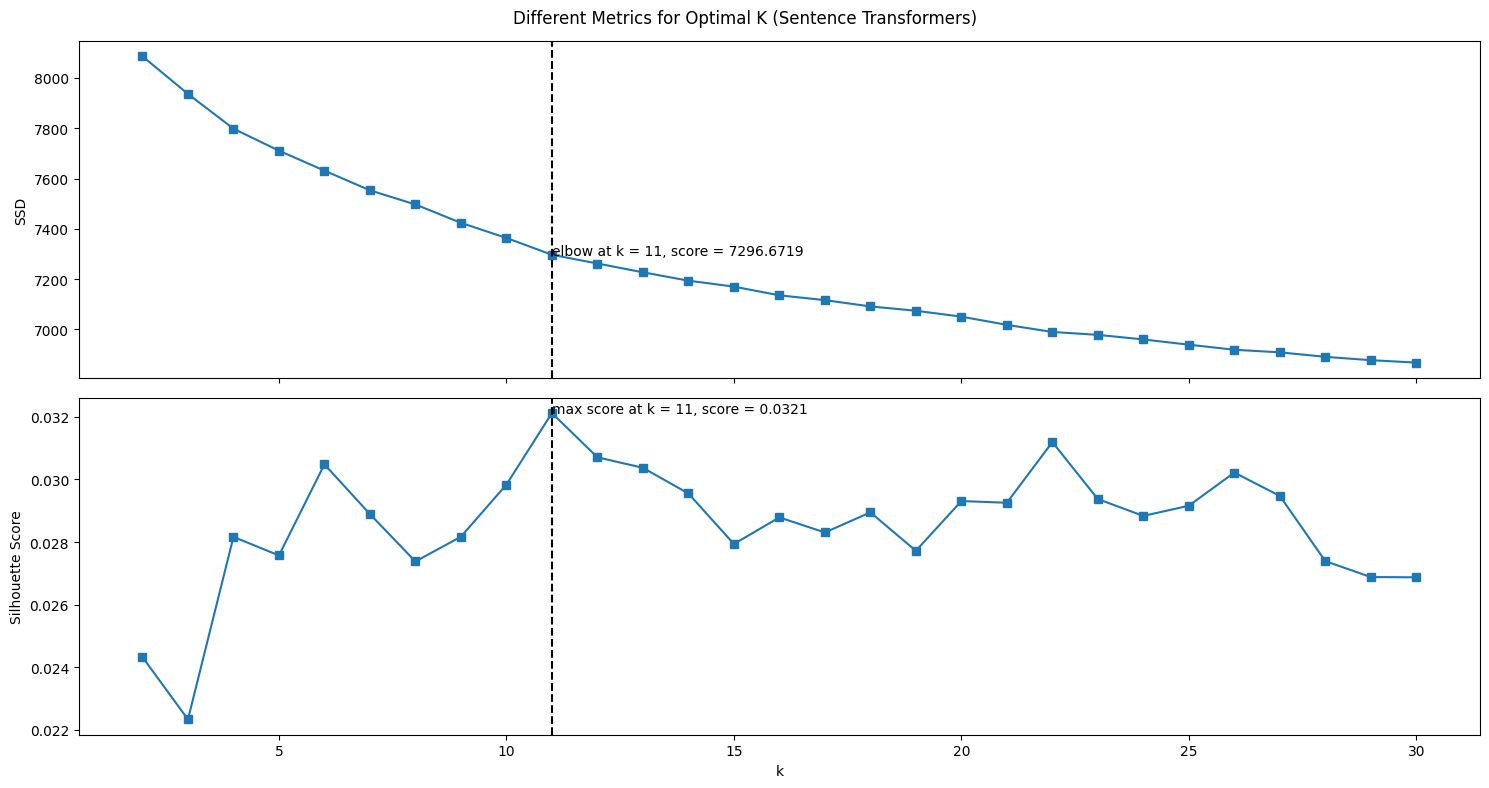

In [20]:
# Display plots for all-MiniLM-L6-v2
metrics_df = create_models(mini_emb)
display_k_plots(metrics_df, 'Sentence Transformers')

When calculating the optimal k value for the sentence transformers embeddings, the same optimal k value is found for both metrics, wheras 2 completely different k values is calculated for gloVe. It seems that the sentence transformers performs better than GloVe. Also, 11 seems to be a reasonable number of clusters. The embeddings calculated with the sentence transformer will be used for the other clustering method.

#### Fit model

In [21]:
kmeans = KMeans(n_clusters=11, random_state=42)
kmeans.fit(mini_emb)

KMeans(n_clusters=11, random_state=42)

In [22]:
labels = kmeans.labels_
df.insert(0, 'cluster', labels)

#### Analyse Clusters

In [23]:
cluster0 = df[df['cluster'] == 0]
cluster0.sample(10)

,cluster,title,text
7064,0,Giza writing board,The Giza writing board (also named Giza king l...
6442,0,Nagpuri literature,Nagpuri literature refers to literature in the...
1672,0,Sushi Hil,Sushi Hil is a Japanese restaurant in Vancouve...
7663,0,Daffa Salman,Muhammad Daffa Salman Zahran Sidik (born 30 Ap...
5664,0,Ganghwa County,Ganghwa County (Korean: 강화군; RR: Ganghwa-gun) ...
7918,0,Molvom Railway Station,Molvom Railway Station coded MLVOM is a railwa...
317,0,Bozo people,"The Bozo (Bambara: ߓߏ߬ߛߏ, romanized: Boso) are..."
1719,0,Korhan Abay,Korhan Abay (born 1 January 1954) is a Turkish...
6115,0,Greater Mahé Region,The Greater Mahe Region includes Mahe municipa...
8140,0,Jayasimha Malla,Jayasimha Malla (Nepali: जयसिंह मल्ल) was the ...


In [24]:
cluster1 = df[df['cluster'] == 1]
cluster1.sample(10)

,cluster,title,text
2406,1,Zemitrella cera,"Zemitrella cera is a species of sea snail, a m..."
1844,1,Bela nuperrima,"Bela nuperrima is a species of sea snail, a ma..."
8492,1,Mayorella marianaensis,Mayorella marianaensis is a species of amoeboz...
5130,1,Sinthusa nasaka,"Sinthusa nasaka, the narrow spark, is a small ..."
3035,1,Platybasia,Platybasia is a spinal disease of a malformed ...
3948,1,Rothmannia lujae,Rothmannia lujae is a midlevel rainforest tree...
7893,1,Synothele moonabie,Synothele moonabie is a species of mygalomorph...
4261,1,Rheoheros,Rheoheros is a genus of cichlids. These freshw...
3503,1,Brady Barr,Brady Robert Barr (born 4 January 1963) is a h...
4684,1,Antaeotricha nuclearis,Antaeotricha nuclearis is a moth in the family...


In [25]:
cluster2 = df[df['cluster'] == 2]
cluster2.sample(10)

,cluster,title,text
490,2,Serre,Serre may refer to:\nSerre (surname)\nSerre (g...
3627,2,Juan Nicolás Callejas Arroyo,Juan Nicolás Callejas Arroyo (9 July 1944 – 21...
3991,2,Andrea Vignali,Andrea Vignali (born 13 June 1991) is an Itali...
242,2,"Ensenada Honda (Ceiba, Puerto Rico)","Ensenada Honda (English: Deep Cove), is an inl..."
7264,2,List of Chileans of German descent,== German Chileans ==\n=== Political figures =...
425,2,Julio Cruz (Argentine footballer),Julio Ricardo Cruz (born 10 October 1974) is a...
7529,2,Elvis Pinel,Elvis Ángel Figueroa Pinel (born 18 December 1...
5623,2,Luigi Scevola,"Luigi Scevola (born Brescia, 1770 – died Milan..."
8290,2,Catholic Church in Somalia,The Catholic Church in Somalia is part of the ...
5839,2,Ali Darmar,"Ali Cemal Darmar (born May 13, 1946) is a Turk..."


In [26]:
cluster3 = df[df['cluster'] == 3]
cluster3.sample(10)

,cluster,title,text
8532,3,Writing FAST,Writing FAST: How to Write Anything with Light...
1486,3,Krazy Kat Invalid,Krazy Kat Invalid is a 1916 silent short anima...
1473,3,Holly Sorensen,Holly Sorensen is an American film producer an...
3485,3,Indigenous Futurisms,Indigenous futurisms is a movement in literatu...
2783,3,Harold Shea,Harold Shea is the protagonist of five science...
2612,3,The Pigeon HAS to Go to School!,The Pigeon HAS to Go to School! is a children'...
8462,3,Kevin Lewis (director),"Kevin Lewis is an American film director, scre..."
4974,3,Kevin Miles (American actor),"Kevin Miles (born Kevin Miles Julian Mimms, Ju..."
925,3,The Best Man (1964 film),The Best Man is a 1964 American political dram...
7727,3,Li Boqing,Li Boqing (Chinese: 李伯清; born in Chengdu in Fe...


In [27]:
cluster4 = df[df['cluster'] == 4]
cluster4.sample(10)

,cluster,title,text
8503,4,26th Grey Cup,"The 26th Grey Cup was played on December 10, 1..."
874,4,Marc Tisseyre,Marc Tisseyre is a French rugby league footbal...
1683,4,Caesar Okhuti,Caesar Okhuti (born 7 October 1990) is a Ugand...
1938,4,Mame Diarra Diouf,Mame Diarra Diouf (born 6 August 1994) is a Se...
7032,4,1953 Eastern Illinois Panthers football team,The 1953 Eastern Illinois Panthers football te...
1449,4,Ryan Mueller,"Ryan Mueller (born April 30, 1991) is an Ameri..."
6217,4,1992 Minnesota Vikings season,The 1992 season was the Minnesota Vikings' 32n...
8502,4,1944 Georgia Tech Yellow Jackets football team,The 1944 Georgia Tech Yellow Jackets football ...
6722,4,Kevin Hart (disambiguation),Kevin Hart (born 1979) is an American actor an...
363,4,John Slaney,"John G. Slaney (born February 7, 1972) is a Ca..."


In [28]:
cluster5 = df[df['cluster'] == 5]
cluster5.sample(10)

,cluster,title,text
3839,5,Hotaru no Hikari,"Hotaru no Hikari (蛍の光, meaning ""Glow of a fire..."
754,5,The Pulse of Awakening,The Pulse of Awakening is the third album by i...
6072,5,Wonder (Akina Nakamori album),Wonder is the third mini studio album by Japan...
7098,5,Angelbite,Angelbite is the fifth studio album by Dutch r...
4740,5,Bag Raiders (album),Bag Raiders is the debut studio album by Austr...
166,5,Moona,Moona is a West African rapper. Known for her ...
7890,5,The Drastics,The Drastics are a roots-oriented dub reggae g...
1998,5,Masaki Satō,"Masaki Satō (佐藤優樹, Satō Masaki) (born May 7, 1..."
3841,5,Cypresses (Dvořák; quartet version),"In 1887, Antonín Dvořák selected 12 of the 18 ..."
5229,5,Golden Hour: Part.2,Golden Hour: Part.2 is the eleventh extended p...


In [29]:
cluster6 = df[df['cluster'] == 6]
cluster6.sample(10)

,cluster,title,text
1935,6,"Feesburg, Ohio",Feesburg is a small unincorporated community i...
2244,6,Birch House,Birch House may refer to:\nBirch House (Falls ...
1427,6,Hanyuan County,Hanyuan County (simplified Chinese: 汉源县; tradi...
5203,6,Deutschheim State Historic Site,Deutschheim State Historic Site is a state-own...
7248,6,"Campbellton, Texas",Campbellton is an unincorporated community in ...
5861,6,National Register of Historic Places listings ...,This is a list of the National Register of His...
592,6,Aldborough (ward),Aldborough is an electoral ward in the London ...
839,6,Freestyle Music Park,"Freestyle Music Park, formerly called Hard Roc..."
4689,6,Kirby Bellars,Kirby Bellars is a village and civil parish ne...
3770,6,Nevadaville Masonic Temple,The Nevadaville Masonic Temple is the Masonic ...


In [30]:
cluster7 = df[df['cluster'] == 7]
cluster7.sample(10)

,cluster,title,text
3492,7,HMBS Leonard C Banfield,HMBS Leonard C Banfield (P 02) is patrol vesse...
4208,7,List of U.S. Air Force acronyms and expressions,"This is a list of initials, acronyms, expressi..."
4758,7,Federal Agency for Tourism,The Federal Agency for Tourism (Rostourism) wa...
4085,7,Clarifying agent,Clarifying agents are used to remove suspended...
5283,7,1995 enlargement of the European Union,The 1995 enlargement of the European Union saw...
4192,7,Tsetse (disambiguation),Tsetse flies are one of the large biting flies...
1194,7,Metagyrate diminished rhombicosidodecahedron,"In geometry, the metagyrate diminished rhombic..."
5629,7,Kepler (microarchitecture),Kepler is the codename for a GPU microarchitec...
6265,7,Necedah Shrine,"Necedah Shrine, officially the Queen of the Ho..."
3563,7,Sisu S-321,"Sisu S-321, S-322 and S-323 is the first lorry..."


In [31]:
cluster8 = df[df['cluster'] == 8]
cluster8.sample(10)

,cluster,title,text
621,8,Lambsheim,Lambsheim is a municipality in the Rhein-Pfalz...
5712,8,Battle of Bereza Kartuska,The Battle of Bereza Kartuska was fought betwe...
208,8,Schesaplana,The Schesaplana (German pronunciation: [ʃezaˈp...
1485,8,Smichov Secondary Technical School,Smichov Secondary Technical School (Czech: Smí...
1623,8,Knutby murder,The Knutby murder (Swedish: Knutbydramat) refe...
4645,8,Ivan Muliarchuk,Ivan Muliarchuk (Ukrainian: Мулярчук Іван Матв...
5032,8,Sayat-Nova,Sayat-Nova (Armenian: Սայեաթ-Նովայ (сlassical)...
6211,8,Skogås,Skogås is a district of Huddinge Municipality ...
6022,8,Hussite Overture,"The Hussite Overture (Czech: Husitská, dramati..."
554,8,"Kashkarovo, Miyakinsky District, Republic of B...",Kashkarovo (Russian: Кашкарово; Bashkir: Ҡашҡа...


In [32]:
cluster9 = df[df['cluster'] == 9]
cluster9.sample(10)

,cluster,title,text
7587,9,Ncell Football,Ncell Football is an initiative that was intro...
8402,9,BMW Ladies Classic,The BMW Ladies Classic was a women's professio...
5869,9,Italy at the 2017 World Championships in Athle...,Italy competed at the 2017 World Championships...
6262,9,1972 Australian Touring Car Championship,The 1972 Australian Touring Car Championship w...
2991,9,2023 FIVB Women's Volleyball Nations League sq...,This article shows the roster of all participa...
2356,9,Kamariny Stadium,The Kamariny Stadium is a multi-purpose stadiu...
1749,9,Astou Ndour-Fall,"Astou Ndour-Fall (née Ndour; born August 22, 1..."
4018,9,Magne Havnå,Magne Havnå (16 September 1963 – 29 May 2004) ...
5641,9,2023 Women's FIH Hockey5s,The 2023 Women's FIH Hockey5s is a women's fie...
6970,9,Rotterdam Ahoy,Rotterdam Ahoy (formerly known as Ahoy Rotterd...


In [33]:
cluster10 = df[df['cluster'] == 10]
cluster10.sample(10)

,cluster,title,text
3471,10,Richard J. Sullivan,"Richard Joseph Sullivan (born April 10, 1964) ..."
827,10,Dickie Dodds,"Thomas Carter Dodds, known in his cricket care..."
231,10,Benjamin M. Friedman,Benjamin Morton Friedman (; born 1944) is an A...
3934,10,Henry Lefroy,Sir Henry Bruce Lefroy (24 March 1854 – 19 Ma...
5317,10,Henry Morris Naglee,"Henry Morris Naglee (January 15, 1815 – March ..."
6281,10,Camille Rolland,Camille Rolland was a French politician (medic...
5195,10,Crosby (surname),"Crosby is an English, Scottish, and Irish surn..."
4148,10,John Erskine of Carnock,John Erskine of Carnock (4 November 1695 – 1 M...
500,10,Henry Alexander Bowler,Henry Alexander Bowler (30 November 1824 – 6 A...
2626,10,Tony Jannus,"Antony Habersack Jannus, more familiarly known..."


##### Observations

0. Asian culture
1. Animals
2. Culture of Spanish and Portuguese-speaking countries
3. People in the show-business, fictional characters, books, movies, writers
4. Team sports
5. Musicians, albumns, songs
6. Cities, schools, parks, stations (urban buildings)
7. Historical events, agriculture, transportation, politics, technologies
8. Eastern European culture
9. Sports events
10. American journalists and politicians

#### Visualize Clusters

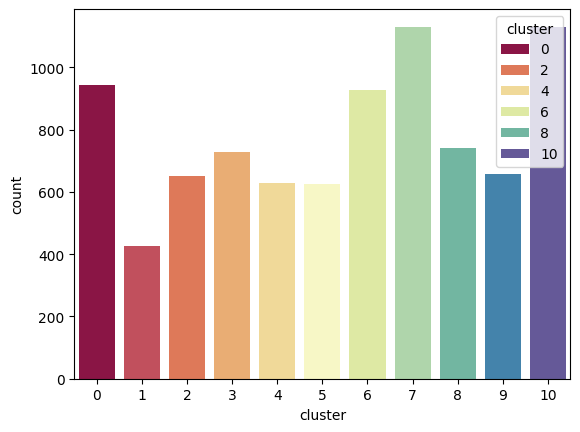

In [34]:
# Plot distribution of the clusters
sns.countplot(data=df, x='cluster', hue='cluster', palette='Spectral');

In [35]:
# Feature reduction
reducer = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = reducer.fit_transform(mini_emb)

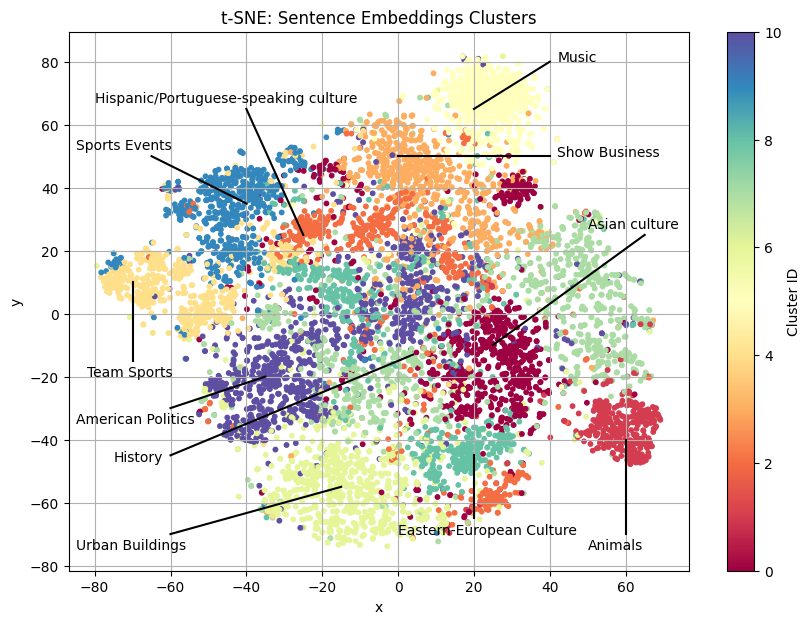

In [36]:
# Visualization
plt.figure(figsize=(10, 7))

# Clusters
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Spectral', s=10)
plt.title('t-SNE: Sentence Embeddings Clusters')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True)

# Descriptions
plt.plot([25, 65], [-10, 25], 'k-')
plt.annotate('Asian culture', xy=(50, 27))
plt.plot([60, 60], [-70, -40],'k-')
plt.annotate('Animals', xy=(50, -75))
plt.plot([-40, -25], [65, 25],'k-')
plt.annotate('Hispanic/Portuguese-speaking culture', xy=(-80, 67))
plt.plot([0, 40], [50, 50],'k-')
plt.annotate('Show Business', xy=(42, 50))
plt.plot([-70, -70], [-15, 10],'k-')
plt.annotate('Team Sports', xy=(-82, -20))
plt.plot([20, 40], [65, 80],'k-')
plt.annotate('Music', xy=(42, 80))
plt.plot([-60, -15], [-70, -55],'k-')
plt.annotate('Urban Buildings', xy=(-85, -75))
plt.plot([-60, 4], [-45, -13],'k-')
plt.annotate('History', xy=(-75, -47))
plt.plot([20, 20], [-45, -65],'k-')
plt.annotate('Eastern-European Culture', xy=(0, -70))
plt.plot([-65, -40], [50, 35],'k-')
plt.annotate('Sports Events', xy=(-85, 52))
plt.plot([-60, -35], [-30, -20],'k-')
plt.annotate('American Politics', xy=(-85, -35))
plt.show()

### Hierarchical Clustering

#### Determine optimal number of clusters from Dendogram

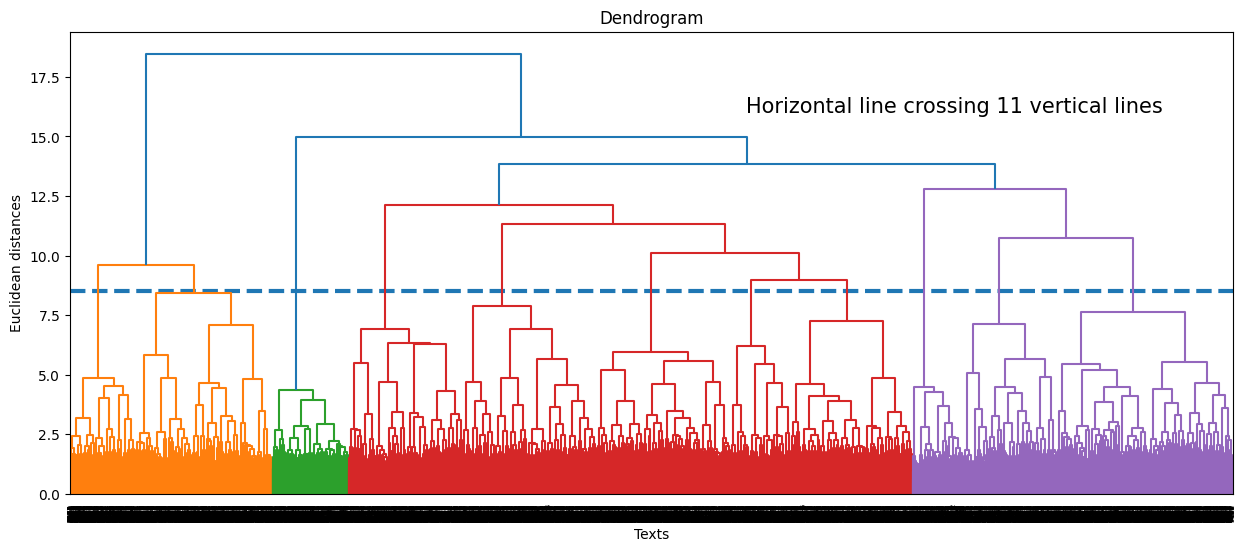

In [37]:
plt.figure(figsize=(15,6))
plt.title('Dendrogram')
plt.xlabel('Texts')
plt.ylabel('Euclidean distances')
plt.hlines(y=8.5, xmin=0, xmax=100000, lw=3, linestyles='--')
plt.text(x=50000, y=16, s='Horizontal line crossing 11 vertical lines',fontsize=15)
dendrogram = sch.dendrogram(sch.linkage(mini_emb, method = 'ward'))
plt.show()

#### Fit model

In [38]:
ac = AgglomerativeClustering(n_clusters= 11, metric='euclidean', linkage='ward')
ac.fit(mini_emb)

AgglomerativeClustering(n_clusters=11)

In [39]:
labels = ac.labels_
df['cluster'] = labels = labels

#### Analyse clusters

In [40]:
cluster0 = df[df['cluster'] == 0]
cluster0.sample(10)

,cluster,title,text
3419,0,Jim Browner,"Jimmie Lee Browner (December 4, 1955 – March 6..."
2172,0,2011 Brisbane Lions season,The 2011 season was the Brisbane Lions' 15th s...
4647,0,Marko Ičelić,Marko Ičelić (Serbian Cyrillic: Марко Ичелић; ...
4140,0,North American and Caribbean Senior Club Champ...,The North American and Caribbean Senior Club C...
6253,0,Hunter Sharp,"Hunter Sharp (born April 25, 1994) is an Ameri..."
3544,0,2007 National League Championship Series,The 2007 National League Championship Series (...
2484,0,2022 South Alabama Jaguars football team,The 2022 South Alabama Jaguars football team r...
3723,0,1936 Howard Bulldogs football team,The 1936 Howard Bulldogs football team was an ...
4246,0,1988 Appalachian State Mountaineers football team,The 1988 Appalachian State Mountaineers footba...
7585,0,Statue of James Meredith,A statue of James Meredith stands on the campu...


In [41]:
cluster1 = df[df['cluster'] == 1]
cluster1.sample(10)

,cluster,title,text
5040,1,Ascó,Ascó (Catalan pronunciation: [asˈko]) is a lar...
2923,1,Toulnustouc River,The Toulnustouc River (French: Rivière Toulnus...
8518,1,Maidstone Museum,Maidstone Museum is a local authority-run muse...
5352,1,Lithology,The lithology of a rock unit is a description ...
1298,1,"Pittsburg, Texas","Pittsburg is a city in, and the county seat of..."
242,1,"Ensenada Honda (Ceiba, Puerto Rico)","Ensenada Honda (English: Deep Cove), is an inl..."
1108,1,Wantagh Park,Wantagh Park is a county park located in south...
5941,1,Toronto government debt,The Toronto government debt is the amount of m...
5143,1,Weston Turville Reservoir,Weston Turville Reservoir is a 19 hectare biol...
5909,1,ALS Limited,ALS Limited (ASX: ALQ) is a company headquarte...


In [42]:
cluster2 = df[df['cluster'] == 2]
cluster2.sample(10)

,cluster,title,text
7074,2,Farzana Sharmin,Farzana Sharmin (also known as Farzana Sharmin...
5179,2,Collin H. Woodward,"Collin H. Woodward (? – September 7, 1927) was..."
1657,2,1992 United States Senate election in North Ca...,The 1992 United States Senate election in Nort...
321,2,Robert Magaw,"Robert Magaw (1738 – January 7, 1790) was an A..."
6392,2,Jacob Egharevba,Chief Jacob Uwadiae Egharevba (1893–1981) was...
7369,2,Politics of São Tomé and Príncipe,The politics of São Tomé and Príncipe takes pl...
818,2,106th New York State Legislature,"The 106th New York State Legislature, consisti..."
7549,2,Helene L. Kaplan,"Helene Lois Kaplan (1933 – January 30, 2023) w..."
5200,2,Lewis Binford,"Lewis Roberts Binford (November 21, 1931 – Apr..."
3000,2,List of New Hampshire Civil War units,List of military units raised by the state of ...


In [43]:
cluster3 = df[df['cluster'] == 3]
cluster3.sample(10)

,cluster,title,text
4713,3,Darby Hinton,"Edgar Raymond Darby Hinton (born August 19, 19..."
8221,3,Per Helander,Per Helander (born 1967) is a Swedish theoreti...
3580,3,Just Our Luck,Just Our Luck is an American sitcom that aired...
487,3,Seven Women (disambiguation),Seven Women or 7 Women is a 1966 film drama.\n...
2670,3,Migraine (book),Migraine is the first book written by Oliver S...
5366,3,Martin Hägglund,Martin Hägglund (Swedish: [ˈhɛɡːlʉnd]; born 23...
2964,3,Faroese Music Awards,"Faroese Music Awards (short form: FMA, in Faro..."
3473,3,71st Tony Awards,The 71st Annual Tony Awards were held on June ...
5238,3,1975 in British radio,This is a list of events in British radio duri...
2002,3,Jacques Chazot,"Jacques Chazot, (b. 25 September 1928 in Locmi..."


In [44]:
cluster4 = df[df['cluster'] == 4]
cluster4.sample(10)

,cluster,title,text
7705,4,Franco Cotana,Franco Cotana (born 22 December 1957 in Marsci...
8347,4,Talamone,"Talamone (Latin: Telamon, Greek: Τελαμών) is a..."
1083,4,Arthur Solinap,"Arthur González Solinap (born January 19, 1980..."
8448,4,1974 in comics,Notable events of 1974 in comics.\n== Events a...
4910,4,Lázaro Valdés,Lázaro Valdés Espinosa (17 December 1940 – 1 J...
7559,4,Athanasius (given name),"Athanasios (Greek: Αθανάσιος), also transliter..."
7474,4,Amy Meyers,Amy R. Weinstein Meyers is an American art his...
5426,4,Dancla Stradivarius (1708),"Dancla violin by Stradivari or Dancla, Milstei..."
4130,4,VDE-Gallo Records,"VDE-Gallo Records is a small record label, bas..."
4565,4,Symphony No. 2 (Davies),The Symphony No. 2 by Peter Maxwell Davies was...


In [45]:
cluster5 = df[df['cluster'] == 5]
cluster5.sample(10)

,cluster,title,text
1768,5,Sentinel Records,Sentinel Records (Sentinel) is an independent ...
4650,5,3-2-1 (Brett Kissel song),"""3-2-1"" is a song recorded by Canadian country..."
5065,5,Delirium (Capercaillie album),Delirium is the fourth studio album by folk ro...
3574,5,"Teddy Bear, Duke & Psycho","Teddy Bear, Duke & Psycho is the fifth studio ..."
2955,5,Martijn Schimmer,Martijn Schimmer (born 21 August 1975) is a Du...
5567,5,Indestructible (Elvis Crespo album),Indestructible is the seventh studio album by ...
1505,5,Ken Casey,"Kenneth William Casey Jr. (born April 15, 1969..."
7080,5,Cliff Friend,"Cliff Friend (October 1, 1893 – June 27, 1974)..."
6919,5,Danny Whitten,"Danny Ray Whitten (May 8, 1943 – November 18, ..."
5105,5,Guido Henneböhl,Guido Henneböhl is a musician and concert orga...


In [46]:
cluster6 = df[df['cluster'] == 6]
cluster6.sample(10)

,cluster,title,text
1954,6,Junagarh Assembly constituency,Junagarh is a Vidhan Sabha constituency of Kal...
6055,6,Long Peluan,Long Peluan is a settlement in the Marudi divi...
5945,6,2023 Wynne–Parkin tornado,"During the afternoon hours of March 31, 2023, ..."
6541,6,Tish Daija,Tish Daija (30 January 1926 – 3 October 2003) ...
3045,6,Bureau of Buddhist and Tibetan Affairs,"The Bureau of Buddhist and Tibetan Affairs, or..."
7851,6,Yngsjö murder,The Yngsjö murder is the common name of one of...
6279,6,The Vendor,The Vendor is a 2018 Nigerian nollywood comedy...
1731,6,Runway (2004 film),Runway is a 2004 Indian Malayalam-language gan...
5902,6,Huailai County,Huailai (simplified Chinese: 怀来县; traditional ...
1700,6,Chottanikkara Temple,The Chottanikkara (correction of Jyotiannakkar...


In [47]:
cluster7 = df[df['cluster'] == 7]
cluster7.sample(10)

,cluster,title,text
834,7,Gustav of Sweden (1568–1607),Gustav Eriksson (28 January 1568 – February 16...
1525,7,History of Czechoslovakia (1989–1992),The last period in Czechoslovak history began ...
7169,7,Mayya (rural locality),"Mayya (Russian: Майя, Yakut: Майа, Maya) is a ..."
6477,7,Burtas,"Burtas (Russian: Буртасы, Burtasy; Chuvash: Пă..."
5431,7,Saint-Honoré,Saint-Honoré refers to various places named af...
1851,7,"Kopnino, Sobinsky District, Vladimir Oblast",Kopnino (Russian: Копнино) is a rural locality...
6438,7,Nancy Jo Powell,"Nancy Jo Powell (born 1947, Cedar Falls, Iowa)..."
4332,7,Markušovce,Markušovce (Slovak pronunciation: [ˈmarkuʂɔwts...
8077,7,Bruno Cornillet,"Bruno Cornillet (born 8 February 1963, in Lamb..."
3459,7,Gornji Hruševec,Gornji Hruševec is a village in Croatia. It is...


In [48]:
cluster8 = df[df['cluster'] == 8]
cluster8.sample(10)

,cluster,title,text
3656,8,Western International Communications,WIC Western International Communications Ltd. ...
4234,8,Rise over thermal,"In wireless communication systems, the rise ov..."
7744,8,Theory of the second best,"In welfare economics, the theory of the second..."
210,8,Makati Business Club,The Makati Business Club is a private non-prof...
7586,8,DNA footprinting,DNA footprinting is a method of in vitro DNA a...
5054,8,Concept Two,"Concept Two, concept ii, CONCEPT 2, or variati..."
3262,8,Kosmos 1658,Kosmos 1658 (Russian: Космос 1658 meaning Cosm...
6505,8,Italian grammar,Italian grammar is the body of rules describin...
2910,8,Self-balancing binary search tree,"In computer science, a self-balancing binary s..."
6436,8,Thiotepa,"Thiotepa (N,N',N''(-triethylenethiophosphorami..."


In [49]:
cluster9 = df[df['cluster'] == 9]
cluster9.sample(10)

,cluster,title,text
5328,9,Rinzia rubra,Rinzia rubra is a plant species of the family ...
6932,9,Lodderena nana,Lodderena nana is a species of small sea snail...
6732,9,Ruspoli's turaco,"Ruspoli's turaco (Menelikornis ruspolii), also..."
550,9,Leodia sexiesperforata,"Leodia sexiesperforata, commonly known as the ..."
3332,9,Conus canonicus,"Conus canonicus, common name the tiger cone, i..."
7913,9,Scymnus marginicollis,Scymnus marginicollis is a species of dusky la...
8280,9,Heterolepis,Heterolepis is a genus of flowering plants in ...
2386,9,Rhion pallidum,Rhion is a monotypic genus of Asian cribellate...
7796,9,Scincella reevesii,Scincella reevesii (common name: Reeves's smoo...
4603,9,Atopomyrmex,Atopomyrmex is a small genus of arboreal ants ...


In [50]:
cluster10 = df[df['cluster'] == 10]
cluster10.sample(10)

,cluster,title,text
2265,10,Roland Ekström,Roland Ekström (born 22 May 1956) is a Swedish...
3893,10,Nigora Tursunkulova,Nigora Tursunkulova (born 4 April 1999) is an ...
2454,10,Denis Matsukevich,Denis Sergeyevich Matsukevich (Дени́с Серге́ев...
2475,10,Para ice hockey at the Winter Paralympics,Para ice hockey at the Winter Paralympics has ...
5507,10,Surtees TS9,The Surtees TS9 was a Formula One car used by ...
7818,10,Coolmore Classic,"The Coolmore Classic, registered as the TAD Ke..."
5589,10,Tamás Lévai,Tamás Lévai is a Hungarian Greco-Roman wrestle...
7177,10,Minella Indo,Minella Indo (foaled 18 April 2013) is an Iris...
756,10,2008 Legg Mason Tennis Classic,The 2008 Legg Mason Tennis Classic was a men's...
6015,10,2015 Abu Dhabi Grand Prix,The 2015 Abu Dhabi Grand Prix (formally known ...


##### Observations

0. Team sports
1. Cultural heritage
2. Politics, armed forces
3. Authors, movies, TV shows, novels, comics, plays, magasines
4. Paintings, opera, photography
5. Music
6. Asian culture
7. Eastern European Culture
8. Business
9. Animals
10. Speed sports (racing, track and field, cycling, swimming)


#### Visualize clusters

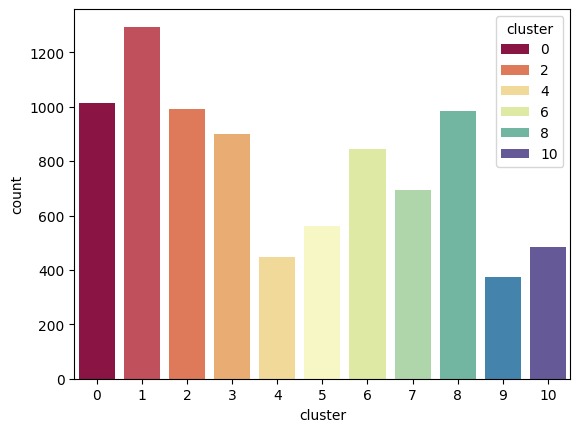

In [51]:
# Plot distribution of the clusters
sns.countplot(data=df, x='cluster', hue='cluster', palette='Spectral');

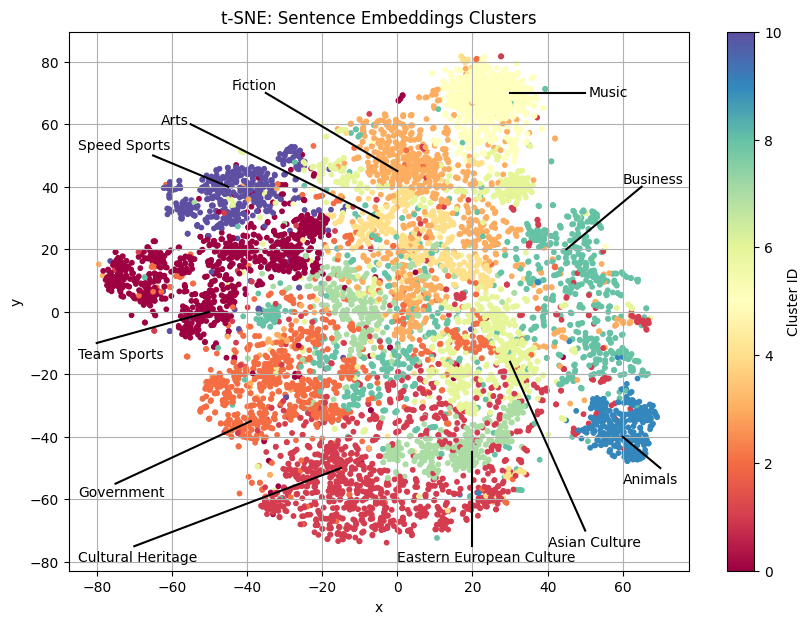

In [52]:
# Visualize clusters
plt.figure(figsize=(10, 7))

# Clusters
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Spectral', s=10)
plt.title('t-SNE: Sentence Embeddings Clusters')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True)

# Descriptions
plt.plot([-80, -50], [-10, 0], 'k-')
plt.annotate('Team Sports', xy=(-85, -15))
plt.plot([-70, -15], [-75, -50],'k-')
plt.annotate('Cultural Heritage', xy=(-85, -80))
plt.plot([-75, -39], [-55, -35],'k-')
plt.annotate('Government', xy=(-85, -59))
plt.plot([-35, 0], [70, 45],'k-')
plt.annotate('Fiction', xy=(-44, 71))
plt.plot([-55, -5], [60, 30],'k-')
plt.annotate('Arts', xy=(-63, 60))
plt.plot([30, 50], [70, 70],'k-')
plt.annotate('Music', xy=(51, 69))
plt.plot([30, 50], [-16, -70],'k-')
plt.annotate('Asian Culture', xy=(40, -75))
plt.plot([20, 20], [-45, -75],'k-')
plt.annotate('Eastern European Culture', xy=(0, -80))
plt.plot([45, 65], [20, 40],'k-')
plt.annotate('Business', xy=(60, 41))
plt.plot([60, 70], [-40, -50],'k-')
plt.annotate('Animals', xy=(60, -55))
plt.plot([-65, -45], [50, 40],'k-')
plt.annotate('Speed Sports', xy=(-85, 52))
plt.show()

## Interpretation

The clusterings are pretty similar and both make sense. Both created clusters for Asian and Eastern Europe culture, and both have two sports clusters, which is interesting.

## End